In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer
from src.utils.result_fetcher import ResultFetcher

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from src.parsers.utils import map_tier, map_strategy, map_architecture

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import itertools

from scipy.stats import ttest_ind, f_oneway

from itertools import combinations

In [3]:
PATH = "/home/tvangraft/tudelft/thesis/metaengineering"

In [4]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

In [5]:
METRIC = 'mdmape_error'
PLOT_KWARGS = {
    'mape_error': {
        'x': 'metabolite_id',
        'y': 'mape_error',
        'palette': 'colorblind',
    },
    'mdmape_error': {
        'x': 'metabolite_id',
        'y': 'median_ape_error',
        'palette': 'colorblind',
    },
    'correlation': {
        'x': 'metabolite_id',
        'y': 'correlation',
        'palette': 'colorblind',
    },
    'mse_error': {
        'x': 'metabolite_id',
        'y': 'mse_error',
        'palette': 'colorblind',
    },
    'error': {
        'x': 'metabolite_id',
        'y': 'error',
        'palette': 'colorblind',
    }
}

SET_KWARGS = {
    'mape_error': {
        'ylabel': 'MAPE of log fold change (%)',
    },
    'correlation': {
        'ylabel': 'Correlation on log fold change',
    },
    'mse_error': {
        'ylabel': 'MSE of log fold change',
    },
    'error': {
        'ylabel': 'MAE of log fold change',
    },
    'mdmape_error': {
        'ylabel': 'Median APE of log fold change (%)',
    },
}

SUITABLE_METABOLITES = ['3pg;2pg', 'dhap', 'f6p', 'pep', 'pyr', 'r5p']

# Result analysis
In this section we aim to analyse the training performance of all the models, we make a comparison over all tiers, over all strategies and we compare architectures to each other

In [6]:
def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

def save_fig(path: str, name: str, extra_artists: set = set()):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight', bbox_extra_artists=extra_artists)
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight', bbox_extra_artists=extra_artists)

def find_significance(df, column_key:str):
    variables = df[column_key].unique()
    for variable_a, variable_b in itertools.combinations(variables, 2):
        list_a = df[df[column_key] == variable_a][PLOT_KWARGS[METRIC]['y']].values
        list_b = df[df[column_key] == variable_b][PLOT_KWARGS[METRIC]['y']].values
        print(f"{variable_a=} less than {variable_b=} with {ttest_ind(list_a, list_b, alternative='less')}")

In [7]:
full_df = pd.read_csv(f"{PATH}/data/results/all_collected_results.csv", index_col=0)
full_df.strategy = full_df.strategy.map(Strategy.from_str)
full_df.experiment_id = full_df.experiment_id.map(Tier.from_str)
full_df

,y_true,y_pred,architecture,metabolite_id,repeat_id,official_name,kegg_id,pathway,method,Order,strategy,experiment_id,error,correlation,mse_error,mape_error,median_ape_error,adjusted_r2,experiment_id_ordering
0,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.7547259209, 0.6264524176, 0.797377106, 0.91...",all,3pg;2pg,0.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.624351,NaN,0.930960,60.603961,25.812028,0.089206,0
1,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.9001374312, 0.6663880895000001, 0.923351585...",all,3pg;2pg,1.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.621525,NaN,0.928443,57.390569,26.235976,0.091668,0
2,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.89532301, 0.4019642524, 0.9173912677, 0.886...",all,3pg;2pg,2.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.580675,NaN,0.897161,51.279072,21.886329,0.122273,0
3,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.7737297082, 0.5229264014, 0.895840242800000...",all,3pg;2pg,3.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.608207,NaN,0.939170,55.493432,23.572616,0.081174,0
4,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[1.0214577545, 0.5144078273, 0.9561493747, 0.7...",all,3pg;2pg,4.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.608770,NaN,0.953282,55.580075,26.023099,0.067368,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5889,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.002068353584036231, -0.002068612026050687,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,1.109843,0.025546,0.658881,100.086477,100.240773,-0.037037,3
5890,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.008101633749902248, -0.008102219551801682,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.880095,0.233839,0.659147,100.338734,100.943102,-0.037037,3
5891,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.009108763188123703, -0.009088517166674137,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.878248,0.253064,0.659197,100.380847,101.059726,-0.037037,3
5892,"[0.6518658995628357, -1.3485695123672485, 0.17...","[0.001019663061015308, 0.003810988273471594, 0...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.877988,-0.273758,0.658736,99.867432,99.920972,-0.037037,3


In [8]:
_df = full_df.copy()
print(_df['strategy'].unique())
_df.strategy = _df.strategy.map(map_strategy)
print(_df['strategy'].unique())
print(_df['experiment_id'].unique())
_df.experiment_id = _df.experiment_id.map(map_tier)


# _df = _df.groupby(['metabolite_id', 'experiment_id', 'strategy']).aggregate({
#     'error': ['mean', 'std'],
#     'mse_error': ['mean', 'std'],
#     'mape_error': ['mean', 'std'],
# }).reset_index()

def pivot(target):
    return _df.pivot_table(
        values=[target],
        index=['experiment_id', 'strategy'],
        columns=['metabolite_id'],
        aggfunc=['mean', 'std'],
        fill_value=0
    )

def f(row: pd.Series):
    def ff(metabolite):
        mean, std = row.xs('pyr', level=2).values
        return f"{mean} +/- {std}"

    return pd.Series(
        [ff(metabolite_id) for metabolite_id in row.index.get_level_values(2).unique()],
        index=row.index.get_level_values(2).unique()
    )
    
df1 = pivot('error').applymap("{0:.2f}".format).apply(lambda row: f(row), axis=1)
df2 = pivot('mse_error').applymap("{0:.2f}".format).apply(lambda row: f(row), axis=1)
df3 = pivot('mape_error').applymap("{0:.2f}%".format).apply(lambda row: f(row), axis=1)

_df = pd.concat([df1, df2, df3], axis=1)
_df.columns = pd.MultiIndex.from_product(
    [
        ['error', 'mse_error', 'mape_error'],
        df1.columns.to_list()
    ],
    names=['error_metric', 'metabolite_id']
)
_df = _df.swaplevel(i='error_metric', j='metabolite_id', axis=1)
_df = _df.reindex(columns=df1.columns.to_list(), level='metabolite_id')
_df = _df.rename(columns={'error': 'MAE', 'mse_error': 'MSE', 'mape_error': 'MAPE'})
_df.to_csv('./data/results/result_overview_table.csv')
_df

[<Strategy.ALL: 'full_dataset'>
 <Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'>
 <Strategy.ONE_VS_ALL: 'one_vs_all'>]
['All metabolite' 'Single metabolite' 'Leave one metabolite out']
[<Tier.TIER0: 'baseline_dataset'> <Tier.TIER1: 'ppi_dataset'>
 <Tier.TIER2: 'protein_stoichiometry'>
 <Tier.TIER3: 'protein_metabolite_stoichiometry'>]


metabolite_id                                              3pg;2pg  \
error_metric                                                   MAE   
experiment_id              strategy                                  
Baseline                   All metabolite            0.60 +/- 0.04   
                           Leave one metabolite out  0.33 +/- 0.06   
                           Single metabolite         1.04 +/- 0.80   
PPI                        All metabolite            0.77 +/- 0.21   
                           Leave one metabolite out  0.41 +/- 0.13   
                           Single metabolite         0.62 +/- 0.03   
Stiochiometric metabolites All metabolite            0.82 +/- 0.14   
                           Leave one metabolite out  0.72 +/- 0.15   
                           Single metabolite         0.84 +/- 0.17   
Stiochiometric protein     All metabolite            0.78 +/- 0.05   
                           Leave one metabolite out  0.70 +/- 0.13   
                           Single metabolite         0.86 +/- 0.10   

metabolite_id                                                        \
error_metric                                                    MSE   
experiment_id              strategy                                   
Baseline                   All metabolite             0.61 +/- 0.10   
                           Leave one metabolite out   0.17 +/- 0.06   
                           Single metabolite         6.65 +/- 10.46   
PPI                        All metabolite             1.12 +/- 0.79   
                           Leave one metabolite out   0.26 +/- 0.16   
                           Single metabolite          0.77 +/- 0.07   
Stiochiometric metabolites All metabolite             0.82 +/- 0.19   
                           Leave one metabolite out   1.01 +/- 0.13   
                           Single metabolite          0.98 +/- 0.28   
Stiochiometric protein     All metabolite             1.17 +/- 0.19   
                           Leave one metabolite out   0.93 +/- 0.18   
                           Single metabolite          0.99 +/- 0.23   

metabolite_id                                                             \
error_metric                                                        MAPE   
experiment_id              strategy                                        
Baseline                   All metabolite               68.76% +/- 3.90%   
                           Leave one metabolite out     42.63% +/- 5.29%   
                           Single metabolite          120.37% +/- 73.51%   
PPI                        All metabolite              94.60% +/- 25.93%   
                           Leave one metabolite out    49.62% +/- 13.01%   
                           Single metabolite            82.59% +/- 2.50%   
Stiochiometric metabolites All metabolite            141.29% +/- 122.58%   
                           Leave one metabolite out   118.63% +/- 37.02%   
                           Single metabolite         171.66% +/- 150.39%   
Stiochiometric protein     All metabolite             118.01% +/- 36.52%   
                           Leave one metabolite out   107.28% +/- 22.91%   
                           Single metabolite          106.67% +/- 29.07%   

metabolite_id                                                 dhap  \
error_metric                                                   MAE   
experiment_id              strategy                                  
Baseline                   All metabolite            0.60 +/- 0.04   
                           Leave one metabolite out  0.33 +/- 0.06   
                           Single metabolite         1.04 +/- 0.80   
PPI                        All metabolite            0.77 +/- 0.21   
                           Leave one metabolite out  0.41 +/- 0.13   
                           Single metabolite         0.62 +/- 0.03   
Stiochiometric metabolites All metabolite            0.82 +/- 0.14   
                           Leave one metab

In [9]:
def make_strategies_plot(df, ax, plot_type: str = 'boxplot'):
    shared_plot_args = dict(
        data=df, x='strategy', y=PLOT_KWARGS[METRIC]['y'],
        palette='Greys', hue='strategy', dodge=False, ax=ax
    )

    if plot_type == 'boxplot':
        g0 = sns.boxplot(
            **shared_plot_args,
            width=.4,
        )
    elif plot_type == 'violin':
        g0 = sns.violinplot(
            **shared_plot_args,
            inner='point',
        )
    g0.set(
        xticklabels=[],
        xlabel="Strategies",
        **SET_KWARGS[METRIC]
    )
    g0.tick_params(bottom=False)
    ax.set_title("A", loc="left")
    g0.get_legend().remove()
    return g0

def make_architecture_plot(df, ax):
    g1 = sns.boxplot(
        data=df,
        x='architecture',
        y=PLOT_KWARGS[METRIC]['y'],
        palette=PLOT_KWARGS[METRIC]['palette'],
        ax=ax,
        width=.4,
    )
    g1.set(
        xticklabels=[],
        xlabel="Architectures",
        **SET_KWARGS[METRIC]
    )
    ax.set_title("B", loc="left")
    g1.tick_params(bottom=False)
    # g1.get_legend().remove()
    return g1

def make_metabolite_plot(df, ax):
    g2 = sns.barplot(
        data=df,
        hue='architecture',
        **PLOT_KWARGS[METRIC],
        ax=ax,
    )

    g2.set_xticklabels(g2.axes.get_xticklabels(), rotation=45)
    g2.set(
        xlabel='Metabolite id',
        **SET_KWARGS[METRIC]
    )
    ax.set_title("C", loc='left')
    g2.get_legend().remove()
    return g2

def make_legend(ax0, ax2):
    handles, labels = ax0.get_legend_handles_labels()
    leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1.02), title='Strategy', alignment='left')
    ax2.add_artist(leg0)

    handles, labels = ax2.get_legend_handles_labels()
    leg1 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 0.75), title='Architecture', alignment='left')
    ax2.add_artist(leg1)
    return (leg0, leg1)

## Baseline model comparison

In [10]:
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all')]  
find_significance(_df, 'strategy')

_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all') & (_df['strategy'] == Strategy.ONE_VS_ALL)]
find_significance(_df, 'architecture')

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=10.26180776218035, pvalue=1.0)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=26.08690962054122, pvalue=1.0)
variable_a=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=6.594888705681169, pvalue=0.9999999999355934)
variable_a='SVR()' less than variable_b='RandomForestRegressor()' with Ttest_indResult(statistic=-3.8778330919574904, pvalue=8.692522266242622e-05)
variable_a='SVR()' less than variable_b='ElasticNet()' with Ttest_indResult(statistic=-13.183452358487143, pvalue=2.9843348451295e-25)
variable_a='SVR()' less than variable_b='MLPRegressor()' with Ttest_indResult(statistic=-4.230053374255979, pvalue=2.3193724573231875e-05)
variable_a='RandomForestRegressor()' le

In [11]:
full_df[full_df['experiment_id'] == Tier.TIER0].architecture.unique()

array(['all', 'SVR()', 'ElasticNet()', 'MLPRegressor()',
       'RandomForestRegressor()'], dtype=object)

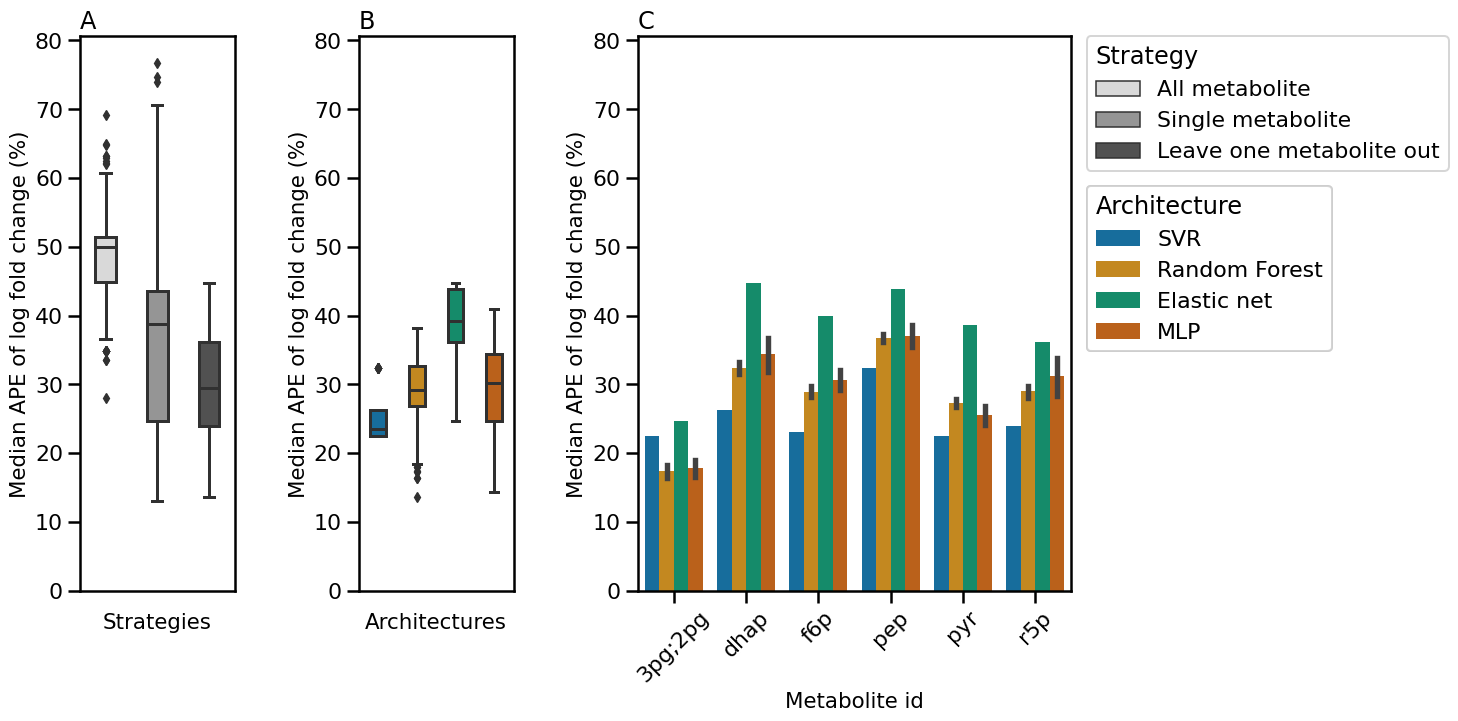

In [12]:
fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_0_STRATEGY = Strategy.ONE_VS_ALL
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all')]

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)

make_strategies_plot(_df, ax0)

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all') & (_df['strategy'] == TIER_0_STRATEGY)]
_df.architecture = _df.architecture.map(map_architecture)
make_architecture_plot(_df, ax1)
make_metabolite_plot(_df, ax2)
leg0, leg1 = make_legend(ax0, ax2)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_0", extra_artists=(leg0, leg1))

<AxesSubplot: xlabel='strategy', ylabel='median_ape_error'>

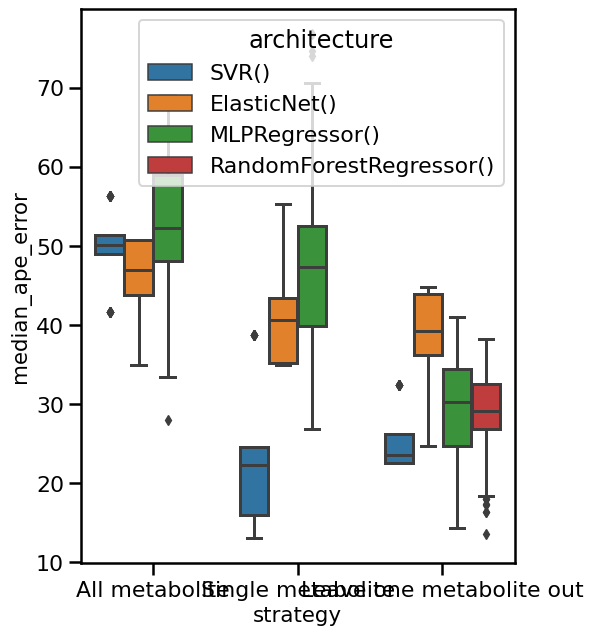

In [13]:
fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_0_STRATEGY = Strategy.ONE_VS_ALL
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all')]

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 2:])

sns.boxplot(
    data=_df,
    x='strategy',
    hue='architecture',
    y=PLOT_KWARGS[METRIC]['y'],
    ax=ax0,
    dodge=True
)

# We reset the dataset long live the copy operator
# save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_0", extra_artists=(leg0, leg1))

## PPI dataset

In [14]:
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all')]  
find_significance(_df, 'strategy')

_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all') & (_df['strategy'] == Strategy.ONE_VS_ALL)]
find_significance(_df, 'architecture')

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=13.581278620141351, pvalue=1.0)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=17.029219626856285, pvalue=1.0)
variable_a=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=2.135496313709265, pvalue=0.9834369416900266)
variable_a='SVR()' less than variable_b='RandomForestRegressor()' with Ttest_indResult(statistic=-13.472021005205983, pvalue=6.375470106646259e-26)
variable_a='SVR()' less than variable_b='ElasticNet()' with Ttest_indResult(statistic=-34.65102941935745, pvalue=5.452474022705705e-64)
variable_a='SVR()' less than variable_b='MLPRegressor()' with Ttest_indResult(statistic=-7.232784369974574, pvalue=3.220561264304206e-12)
variable_a='RandomForestRegressor()' 

<Figure size 1279.68x720 with 0 Axes>

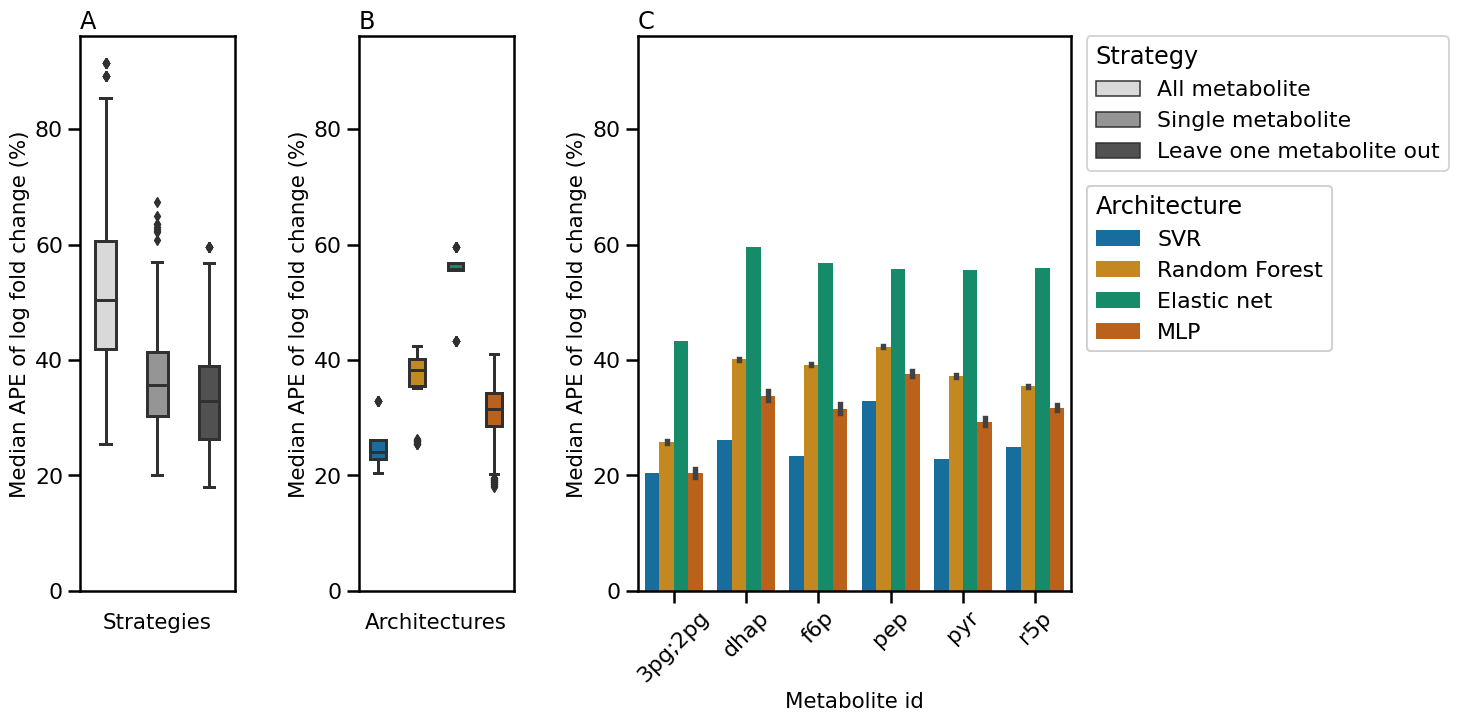

In [15]:
set_context(MODE)
fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_1_STRATEGY = Strategy.ONE_VS_ALL
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)

make_strategies_plot(_df, ax0)

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all') & (_df['strategy'] == TIER_1_STRATEGY)]
_df.architecture = _df.architecture.map(map_architecture)
make_architecture_plot(_df, ax1)
make_metabolite_plot(_df, ax2)
leg0, leg1 = make_legend(ax0, ax2)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_1", extra_artists=(leg0, leg1))

## Stoichiomety protein only

In [16]:
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER2) & (_df['architecture'] != 'all')]  
find_significance(_df, 'strategy')

_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER2) & (_df['architecture'] != 'all') & (_df['strategy'] == Strategy.ONE_VS_ALL)]
find_significance(_df, 'architecture')

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=2.203353971483006, pvalue=0.9859169743754479)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=-4.218566066400769, pvalue=1.5369766285283146e-05)
variable_a=<Strategy.ONE_VS_ALL: 'one_vs_all'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=-5.15205735785986, pvalue=2.0691722230065864e-07)
variable_a='strict' less than variable_b='full' with Ttest_indResult(statistic=0.7794493190087923, pvalue=0.7816575636634822)


<Figure size 1279.68x720 with 0 Axes>

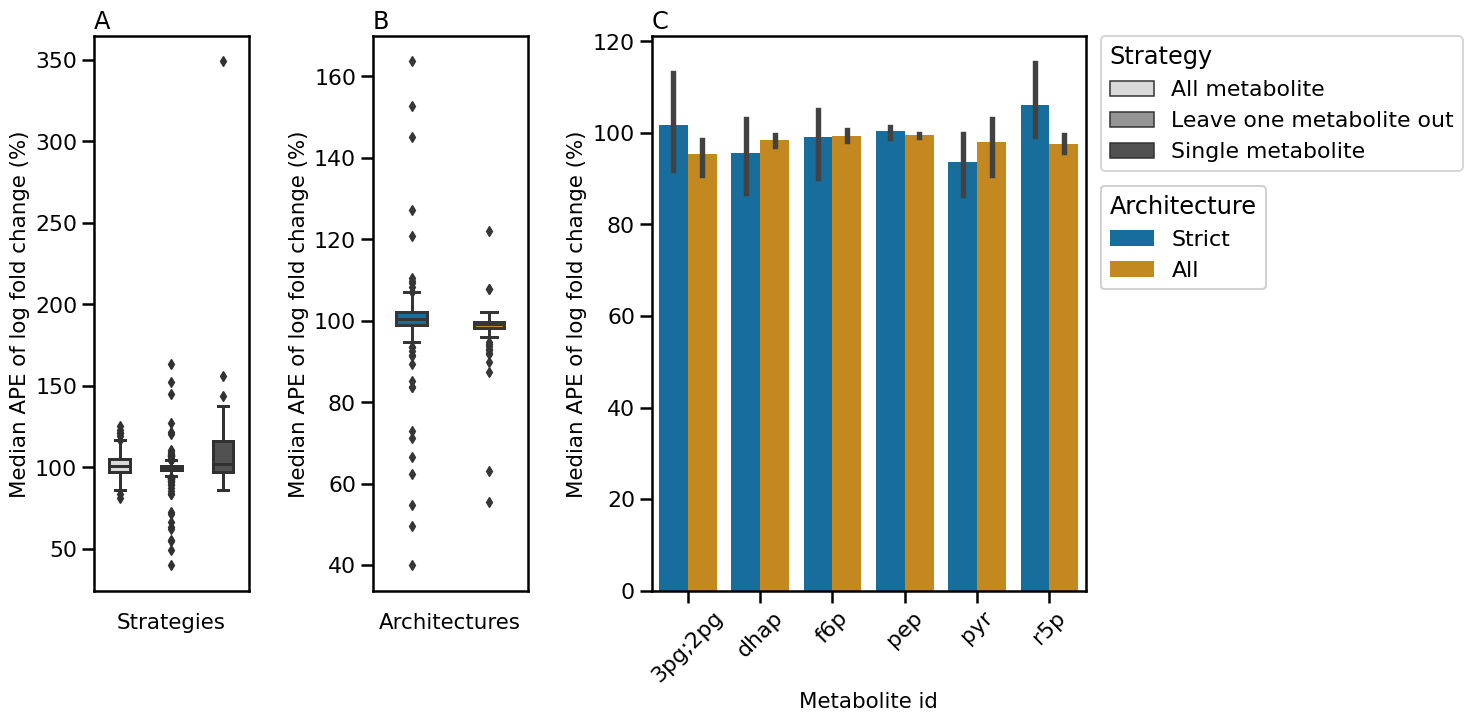

In [17]:
TIER = Tier.TIER2
TIER_2_STRATEGY = Strategy.ONE_VS_ALL

set_context(MODE)
fig = set_context(MODE)
NROWS, NCOLS = 1, 4
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2:])

make_strategies_plot(_df, ax0)
ax0.set_title("A", loc='left')

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all') & (_df['strategy'] == TIER_2_STRATEGY)]
_df.architecture = _df.architecture.map({
    "strict": 'Strict', 
    "full": 'All', 
})

make_architecture_plot(_df, ax1)
ax1.set_title("B", loc='left')

make_metabolite_plot(_df, ax2)
ax2.set_title("C", loc='left')

leg0, leg1 = make_legend(ax0, ax2)
save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_2", extra_artists=(leg0, leg1))

## Stoichiometry full model

In [18]:
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER3) & (_df['architecture'] != 'all')]  
find_significance(_df, 'strategy')

_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER3) & (_df['architecture'] != 'all') & (_df['strategy'] == Strategy.ONE_VS_ALL)]
find_significance(_df, 'architecture')

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=-3.484950618654811, pvalue=0.0002746750594640571)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=-0.4512570339574081, pvalue=0.32605889693215745)
variable_a=<Strategy.ONE_VS_ALL: 'one_vs_all'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=2.439944731148869, pvalue=0.9923770018273338)
variable_a='strict' less than variable_b='full' with Ttest_indResult(statistic=-4.543355650040983, pvalue=4.913279925834921e-06)


<Figure size 1279.68x720 with 0 Axes>

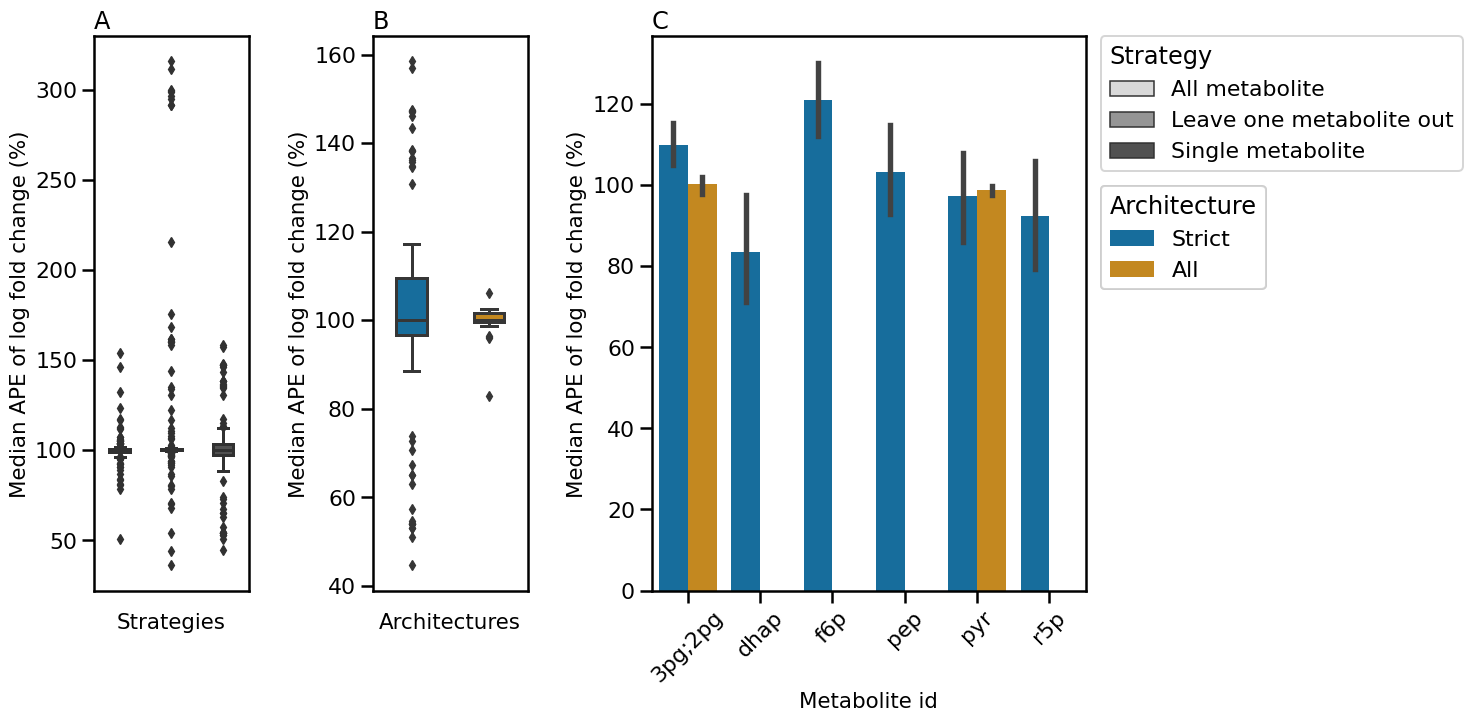

In [19]:
TIER = Tier.TIER3
TIER_3_STRATEGY = Strategy.METABOLITE_CENTRIC
set_context(MODE)
_df = full_df.copy()

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2:])

make_strategies_plot(_df, ax0)
ax0.set_title("A", loc='left')

# We reset the dataset long live the copy operator
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == TIER) & (_df['architecture'] != 'all') & (_df['strategy'] == TIER_3_STRATEGY)]
_df.architecture = _df.architecture.map({
    "strict": 'Strict', 
    "full": 'All', 
})

make_architecture_plot(_df, ax1)
ax1.set_title("B", loc='left')

make_metabolite_plot(_df, ax2)
ax2.set_title("C", loc='left')

leg0, leg1 = make_legend(ax0, ax2)
save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_3", extra_artists=(leg0, leg1))

## Strategy comparison
An overview of the effect of using the data strategy for each tier. We see that the `All metabolite` strategy is the best performing strategy over all experiments (Panel A). 

<Figure size 1279.68x720 with 0 Axes>

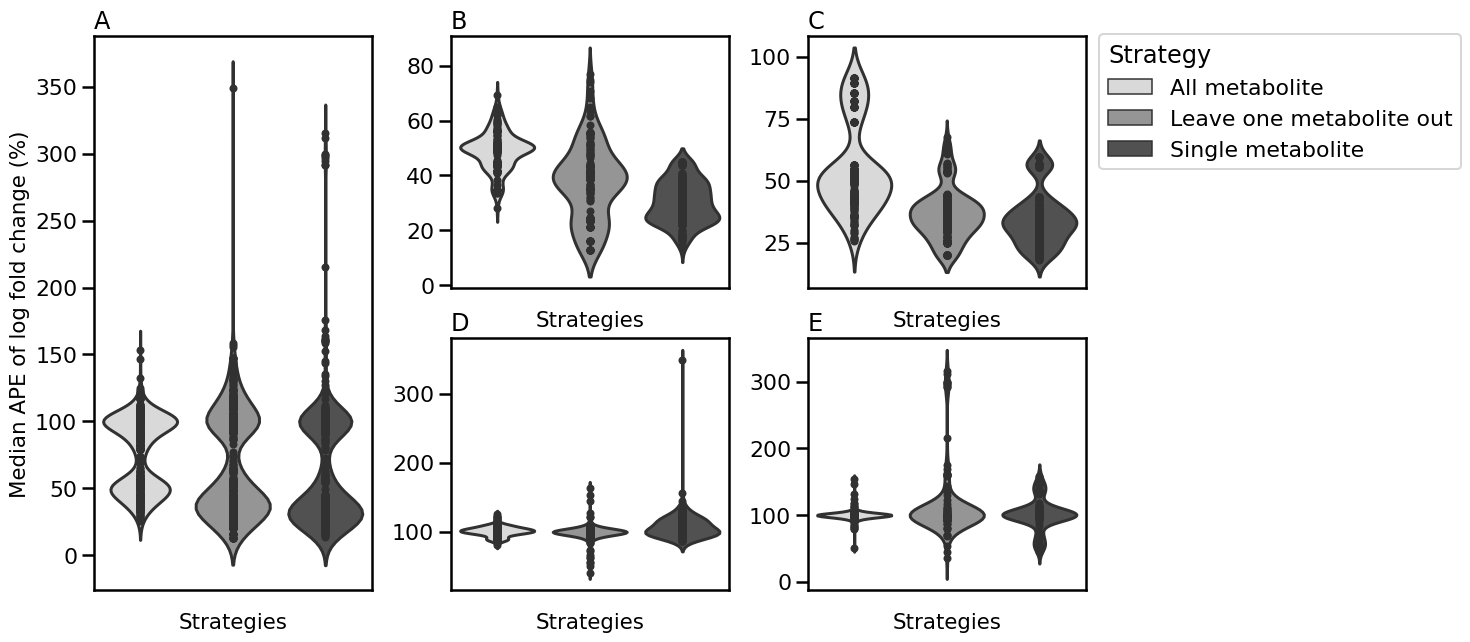

In [20]:
set_context(MODE)
_df = full_df.copy()

fig = set_context(MODE)
NROWS, NCOLS = 2, 6
_df = full_df.copy()
_df = _df[(_df['architecture'] != 'all')]
_df['mape_error'] = _df['mape_error'] * 100

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.ONE_VS_ALL: 'Single metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Leave one metabolite out',
})

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[:, :2])
ax1 = fig.add_subplot(gs[0, 2:4])
ax2 = fig.add_subplot(gs[0, 4:6])
ax3 = fig.add_subplot(gs[1, 2:4])
ax4 = fig.add_subplot(gs[1, 4:6])

# We reset the dataset long live the copy operator
make_strategies_plot(_df, ax0, plot_type='violin')
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER0)], ax1, plot_type='violin').set(ylabel=None)
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER1)], ax2, plot_type='violin').set(ylabel=None)
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER2)], ax3, plot_type='violin').set(ylabel=None)
make_strategies_plot(_df[(_df['architecture'] != 'all') & (_df['experiment_id'] == Tier.TIER3)], ax4, plot_type='violin').set(ylabel=None)

ax0.set_title("A", loc='left')
ax1.set_title("B", loc='left')
ax2.set_title("C", loc='left')
ax3.set_title("D", loc='left')
ax4.set_title("E", loc='left')

handles, labels = ax0.get_legend_handles_labels()
leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 2.25), title='Strategy', alignment='left')
# ax2.add_artist(leg0)

# print(handles)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_strategies_over_all_plots", extra_artists=[leg0])
plt.show()

## Tier comparison

In [21]:
_df = full_df.copy()
_df = _df[
    (_df['architecture'] != 'all') &
    (
        ((_df['experiment_id'] == Tier.TIER0) & (_df['strategy'] == Strategy.ALL) & (_df['architecture'] == 'SVR()')) |
        ((_df['experiment_id'] == Tier.TIER1) & (_df['strategy'] == Strategy.METABOLITE_CENTRIC) & (_df['architecture'] == 'RandomForestRegressor()')) |
        ((_df['experiment_id'] == Tier.TIER2) & (_df['strategy'] == Strategy.ONE_VS_ALL) & (_df['architecture'] == 'strict')) |
        ((_df['experiment_id'] == Tier.TIER3) & (_df['strategy'] == Strategy.METABOLITE_CENTRIC) & (_df['architecture'] == 'strict')) 
    )
]

find_significance(_df, 'experiment_id')

_df

variable_a=<Tier.TIER0: 'baseline_dataset'> less than variable_b=<Tier.TIER1: 'ppi_dataset'> with Ttest_indResult(statistic=8.393852352829079, pvalue=0.9999999999999404)
variable_a=<Tier.TIER0: 'baseline_dataset'> less than variable_b=<Tier.TIER2: 'protein_stoichiometry'> with Ttest_indResult(statistic=-23.474323436683413, pvalue=4.8488431076364125e-53)
variable_a=<Tier.TIER0: 'baseline_dataset'> less than variable_b=<Tier.TIER3: 'protein_metabolite_stoichiometry'> with Ttest_indResult(statistic=-15.348997945791156, pvalue=3.7671577689008675e-33)
variable_a=<Tier.TIER1: 'ppi_dataset'> less than variable_b=<Tier.TIER2: 'protein_stoichiometry'> with Ttest_indResult(statistic=-26.776863989281864, pvalue=4.0343977367442576e-60)
variable_a=<Tier.TIER1: 'ppi_dataset'> less than variable_b=<Tier.TIER3: 'protein_metabolite_stoichiometry'> with Ttest_indResult(statistic=-17.873889030942596, pvalue=1.0757241113862067e-39)
variable_a=<Tier.TIER2: 'protein_stoichiometry'> less than variable_b=<Tie

,y_true,y_pred,architecture,metabolite_id,repeat_id,official_name,kegg_id,pathway,method,Order,strategy,experiment_id,error,correlation,mse_error,mape_error,median_ape_error,adjusted_r2,experiment_id_ordering
10,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.104677533, 0.7724860995, 0.7978382006, 0.89...",SVR(),3pg;2pg,0.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.695724,NaN,0.965686,69.350075,49.848036,0.055232,0
11,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.104677533, 0.7724860995, 0.7978382006, 0.89...",SVR(),3pg;2pg,1.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.695724,NaN,0.965686,69.350075,49.848036,0.055232,0
12,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.104677533, 0.7724860995, 0.7978382006, 0.89...",SVR(),3pg;2pg,2.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.695724,NaN,0.965686,69.350075,49.848036,0.055232,0
13,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.104677533, 0.7724860995, 0.7978382006, 0.89...",SVR(),3pg;2pg,3.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.695724,NaN,0.965686,69.350075,49.848036,0.055232,0
14,"[-1.4913663173, -0.5617994757, 0.9582807563, 1...","[0.104677533, 0.7724860995, 0.7978382006, 0.89...",SVR(),3pg;2pg,4.0,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.695724,NaN,0.965686,69.350075,49.848036,0.055232,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5889,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.002068353584036231, -0.002068612026050687,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,1.109843,0.025546,0.658881,100.086477,100.240773,-0.037037,3
5890,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.008101633749902248, -0.008102219551801682,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.880095,0.233839,0.659147,100.338734,100.943102,-0.037037,3
5891,"[0.6518658995628357, -1.3485695123672485, 0.17...","[-0.009108763188123703, -0.009088517166674137,...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.878248,0.253064,0.659197,100.380847,101.059726,-0.037037,3
5892,"[0.6518658995628357, -1.3485695123672485, 0.17...","[0.001019663061015308, 0.003810988273471594, 0...",strict,r5p,NaN,alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3,Strategy.METABOLITE_CENTRIC,Tier.TIER3,0.877988,-0.273758,0.658736,99.867432,99.920972,-0.037037,3


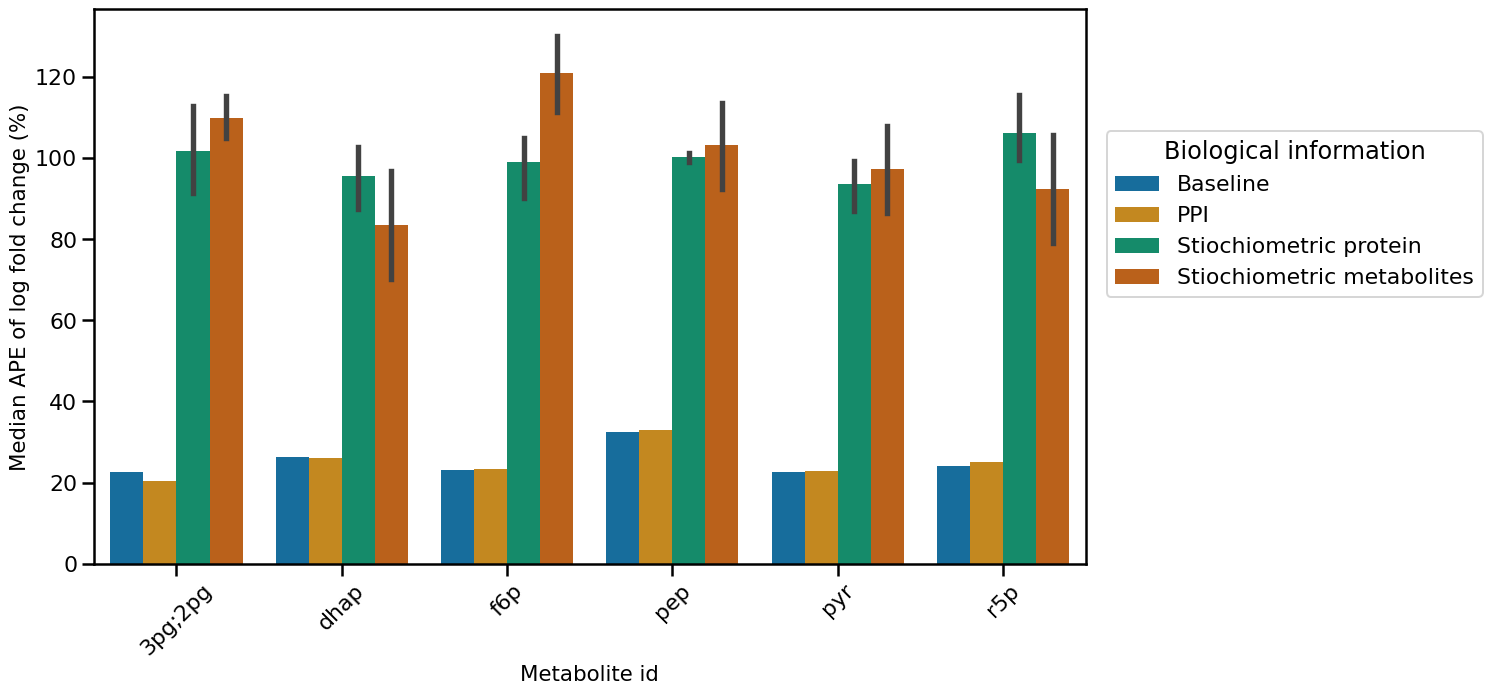

In [22]:
set_context(MODE)
_df = full_df.copy()
_df = _df[
    (_df['architecture'] != 'all') &
    (
        ((_df['experiment_id'] == Tier.TIER0) & (_df['strategy'] == TIER_0_STRATEGY) & (_df['architecture'] == 'SVR()')) |
        ((_df['experiment_id'] == Tier.TIER1) & (_df['strategy'] == TIER_1_STRATEGY) & (_df['architecture'] == 'SVR()')) |
        ((_df['experiment_id'] == Tier.TIER2) & (_df['strategy'] == TIER_2_STRATEGY) & (_df['architecture'] == 'strict')) |
        ((_df['experiment_id'] == Tier.TIER3) & (_df['strategy'] == TIER_3_STRATEGY) & (_df['architecture'] == 'strict')) 
    )
]

_df.experiment_id = _df.experiment_id.map(map_tier)

g = sns.barplot(
    data=_df,
    hue='experiment_id',
    **PLOT_KWARGS[METRIC],
)


g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
leg0 = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Biological information')

g.set(
    xlabel='Metabolite id',
    **SET_KWARGS[METRIC]
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_different_tiers_using_optimal_model", extra_artists=[leg0])

# Metabolite analysis

ValueError: min() arg is an empty sequence

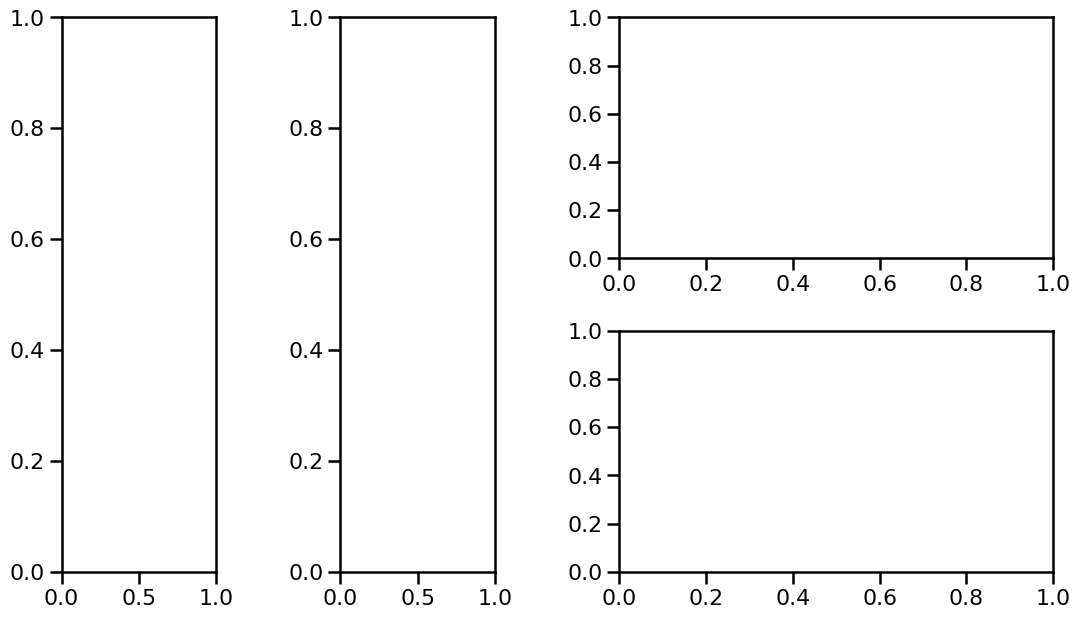

In [23]:
def absolute_percentage_error(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    ape = np.abs(y_pred - y_true) / np.abs(y_true)
    return ape * 100

fig = set_context(MODE)
NROWS, NCOLS = 2, 4
BINWIDTH = 10

_df = full_df.copy()
_df = _df[
    (_df['experiment_id'] == Tier.TIER0) & 
    (_df['architecture'] != 'all') & 
    (_df['strategy'] == Strategy.METABOLITE_CENTRIC) &
    (_df['architecture'] == 'SVR()') &
    ((_df['metabolite_id'] == 'f6p') | (_df['metabolite_id'] == 'pep'))
]


_df
gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8, hspace=.3)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 2:], sharex=ax2, sharey=ax2)

g = sns.boxplot(
    data=_df[_df['repeat_id'] == '0'][['metabolite_id', 'y_true']].explode('y_true'),
    x='metabolite_id',
    y='y_true',
    ax=ax0,
    palette=PLOT_KWARGS[METRIC]['palette'],
    width=.4,
)
g.set(
    xticklabels=[],
    xlabel="Metabolites",
    ylabel='Metabolite fold-change',
    
)
g.tick_params(bottom=False)

_df['ape'] = _df.apply(lambda row: absolute_percentage_error(row['y_true'], row['y_pred']), axis=1)
_df = _df[['metabolite_id', 'ape']].explode('ape').reset_index(drop=True)

g0 = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='ape',
    hue='metabolite_id',
    dodge=False,
    palette=PLOT_KWARGS[METRIC]['palette'],
    width=.4,
    ax=ax1,
)
g0.get_legend().remove()
g0.set(
    xticklabels=[],
    xlabel="Metabolites",
    ylabel='APE of log fold change (%)'
)
g0.tick_params(bottom=False)

g1 = sns.histplot(
    data=_df[_df['metabolite_id'] == 'f6p'],
    x='ape',
    binwidth=BINWIDTH,
    multiple='dodge',
    kde=True,
    ax=ax2,
    color=sns.color_palette('colorblind')[0],
    # element='poly',
)

g1.set(
    xlabel=None,
    ylabel="Frequency of APE",
    xlim=[0, 200]
)

g2 = sns.histplot(
    data=_df[_df['metabolite_id'] == 'pep'],
    x='ape',
    binwidth=BINWIDTH,
    multiple='dodge',
    kde=True,
    ax=ax3,
    color=sns.color_palette('colorblind')[1],
)

g2.set(
    xlabel=None,
    ylabel="Frequency of APE",
    xlim=[0, 200]
)

ax0.set_title("A", loc='left')
ax1.set_title("B", loc='left')
ax2.set_title("C", loc='left')
ax3.set_title("D", loc='left')

handles, labels = ax1.get_legend_handles_labels()
print(labels)
leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 2.35
                                                                     ), title='Metabolites', alignment='left')
# ax2.add_artist(leg0)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_f6p_and_pep", extra_artists=[leg0])

# Deep dive into pyruvate

In [ ]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

strategy = Strategy.ALL
gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f832db7bbb0>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f832db7bb20>>])


In [ ]:
# PDC1, PDC2, PDC5, PDC6
pdc_enzymes = ["YLR044C", "YDR081C", "YLR134W", "YGR087C"]

for pdc_enzyme in pdc_enzymes:
    if pdc_enzyme in tf.x.columns:
        print(pdc_enzyme)

YLR044C
YGR087C


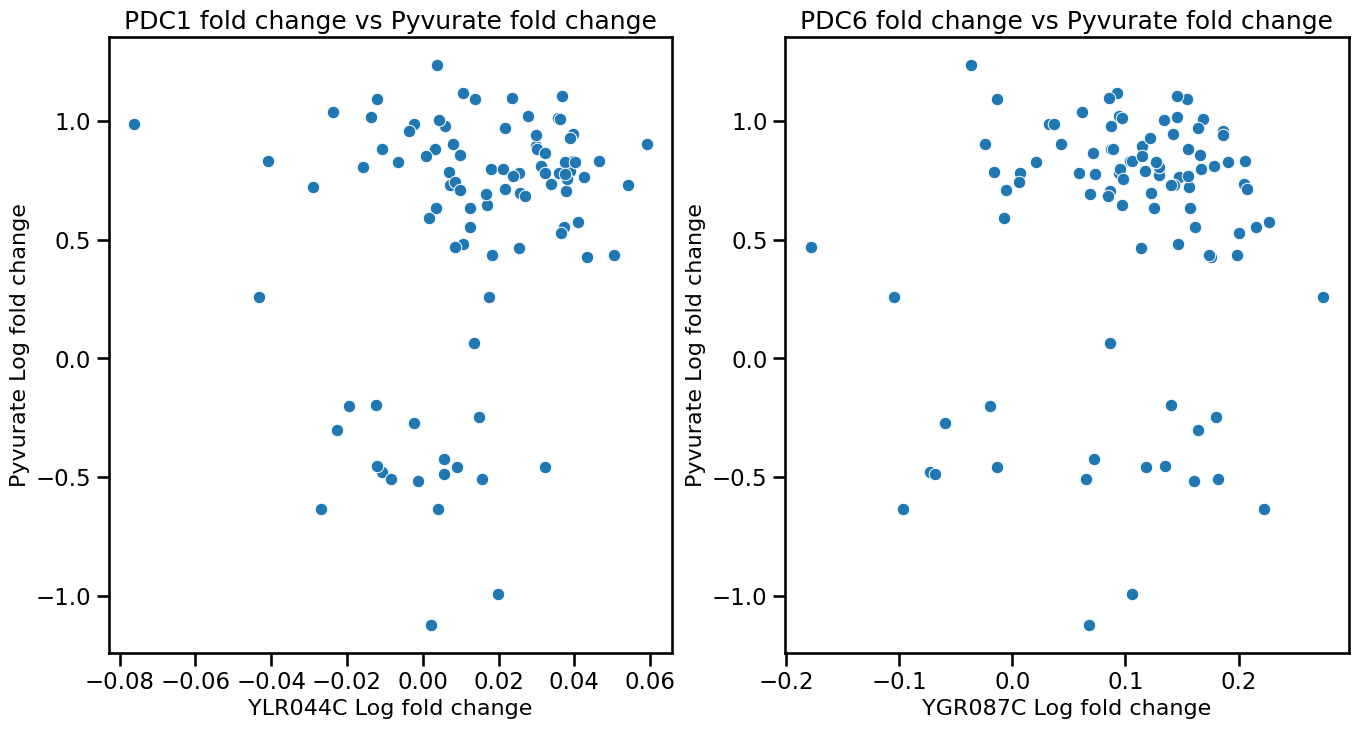

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="pyr",
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="pyr",
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()

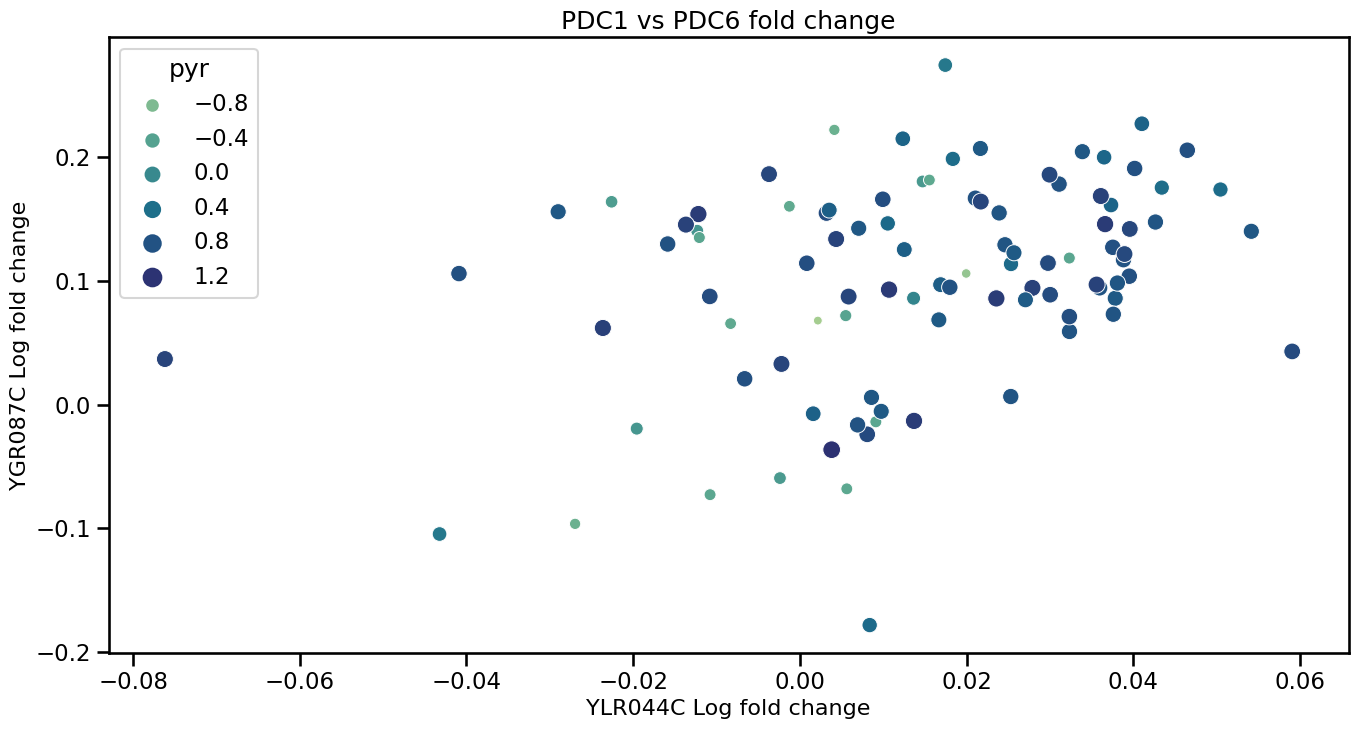

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="YGR087C",
    hue='pyr',
    size='pyr',
    palette='crest',
    ax=ax1,
).set(
    title='PDC1 vs PDC6 fold change',
    xlabel='YLR044C Log fold change',
    ylabel='YGR087C Log fold change'
)
plt.show()

# Load optimal model

In [ ]:
with open(f'./model/Tier.TIER0/Strategy.ALL_all.pickle', 'rb') as handle:
    model = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.METABOLITE_CENTRIC_pyr.pickle', 'rb') as handle:
    model_tier_0_metabolite_strategy = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.ONE_VS_ALL_pyr.pickle', 'rb') as handle:
    model_tier_0_one_vs_all = pickle.load(handle)

predictions = model.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_metabolite = model_tier_0_metabolite_strategy.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_one_vs_all = model_tier_0_one_vs_all.predict(tf.x.xs(key='pyr', axis=0, level=1))

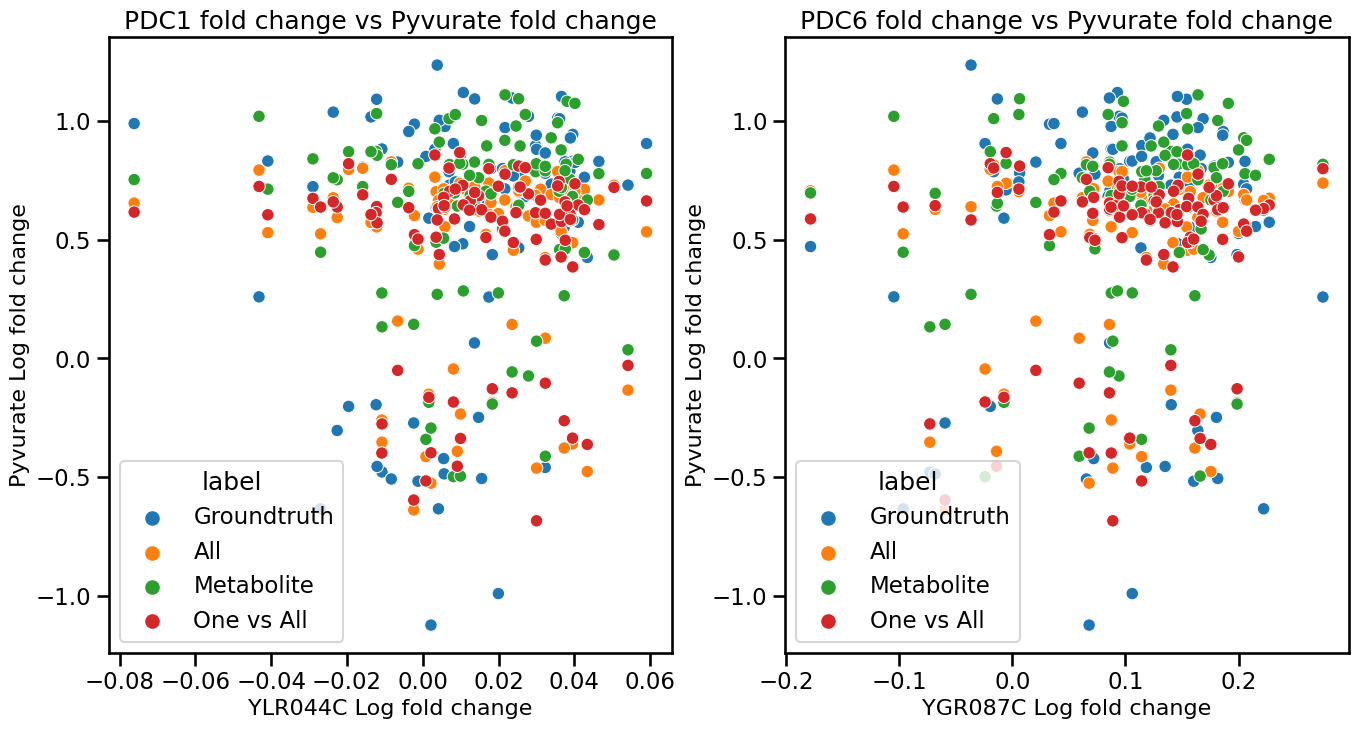

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

_df = _df.assign(predictions=predictions)
_df = _df.assign(predictions_metabolite=predictions_metabolite)
_df = _df.assign(predictions_one_vs_all=predictions_one_vs_all)
_df = _df[['YLR044C', 'YGR087C', 'pyr', 'predictions', 'predictions_metabolite', 'predictions_one_vs_all']].reset_index()

_df = pd.concat([
    _df[['YLR044C', 'YGR087C', 'pyr']].rename({'pyr': 'fc'}, axis=1).assign(label='Groundtruth'),
    _df[['YLR044C', 'YGR087C', 'predictions']].rename({'predictions': 'fc'}, axis=1).assign(label='All'),
    _df[['YLR044C', 'YGR087C', 'predictions_metabolite']].rename({'predictions_metabolite': 'fc'}, axis=1).assign(label='Metabolite'),
    _df[['YLR044C', 'YGR087C', 'predictions_one_vs_all']].rename({'predictions_one_vs_all': 'fc'}, axis=1).assign(label='One vs All'),
], axis=0, ignore_index=True)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="fc",
    hue='label',
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="fc",
    hue='label',
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()